In [67]:
import zipfile
import os
import cv2
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.feature import hog
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score,recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pandas as pd


In [68]:
from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/export-20241112T162103Z-001.zip'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:


# Define the path to your zip file in Colab
zip_file_path = '/content/export-20241112T162103Z-001.zip'
extracted_folder_path = '/content/data/'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Define paths to the extracted data
export_folder_path = os.path.join(extracted_folder_path, 'export')
annotations_path = os.path.join(export_folder_path, '_annotations.csv')

# Load the annotations CSV file
annotations_df = pd.read_csv(annotations_path)

folder_path = extracted_folder_path

# Display the first few rows to confirm successful loading
print(annotations_df.head())

                                            filename  width  height  \
0  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   

        class  xmin  ymin  xmax  ymax  
0         car   291   247   370   331  
1  pedestrian   270   235   293   321  
2         car     0   266    13   327  
3         car    25   258   106   304  
4         car   111   259   135   289  


In [70]:
image_size = (64, 64)  # Resize images to a smaller dimension for faster processing
n_clusters = 5  # Arbitrary number of clusters for unsupervised learning


In [72]:
import os
import numpy as np
from PIL import Image

def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        # Check if the file is an image before processing
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # Add other image extensions if needed
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).resize(image_size).convert('L')  # Convert to grayscale for simplicity
            img = np.array(img) / 255.0  # Normalize
            images.append(img)
    return np.array(images)

In [73]:
import random # Import the random module

def simulate_labels(num_images):  # Define simulate_labels function
    """
    This function simulates labels for unsupervised learning.
    It randomly assigns labels from a set of predefined categories.
    """
    categories = ['car', 'pedestrian', 'truck', 'trafficLight', 'biker']  # Example categories
    labels = [random.choice(categories) for _ in range(num_images)]
    return np.array(labels)

# Load images and generate simulated labels
dataset_path = os.path.join(extracted_folder_path, 'export')
images = load_images(dataset_path)
labels = simulate_labels(len(images))  # Generate simulated labels

In [74]:
# Extract HOG features for image descriptors
def extract_hog_features(images):
    hog_features = []
    for image in images:
        features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

# Optimal Clustering using Silhouette Score
def find_optimal_clusters(features, max_clusters=10):
    best_clusters, best_score = 2, -1
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
        score = silhouette_score(features, cluster_labels)
        if score > best_score:
            best_clusters, best_score = n_clusters, score
    print(f"Optimal Clusters: {best_clusters}, Silhouette Score: {best_score:.4f}")
    return best_clusters

In [75]:
hog_features = extract_hog_features(images)


In [76]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(hog_features)


In [77]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.2, random_state=42)



In [78]:
# Initialize machine learning models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}



In [79]:
# Hyperparameter Tuning
grid_params = {
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [10, 20, None]},
    "SVM": {"C": [0.1, 1, 10]},
    "KNN": {"n_neighbors": [3, 5, 7]}
}

In [80]:
import itertools
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    param_grid_key = 'KNN' if model_name == 'K-Nearest Neighbors' else model_name
    param_grid = grid_params[param_grid_key]
    best_model, best_score = None, 0
    for params in (dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())):
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_score:
            best_model, best_score = model, accuracy

    y_pred = best_model.predict(X_test)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        "Accuracy": best_score,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm
    }

Training Random Forest...
Training SVM...
Training K-Nearest Neighbors...


Random Forest - Accuracy: 0.18, F1 Score: 0.17
              precision    recall  f1-score   support

       biker       0.16      0.19      0.17        37
         car       0.27      0.27      0.27        45
  pedestrian       0.08      0.10      0.09        30
trafficLight       0.15      0.13      0.14        52
       truck       0.23      0.17      0.20        40

    accuracy                           0.18       204
   macro avg       0.18      0.17      0.17       204
weighted avg       0.18      0.18      0.18       204



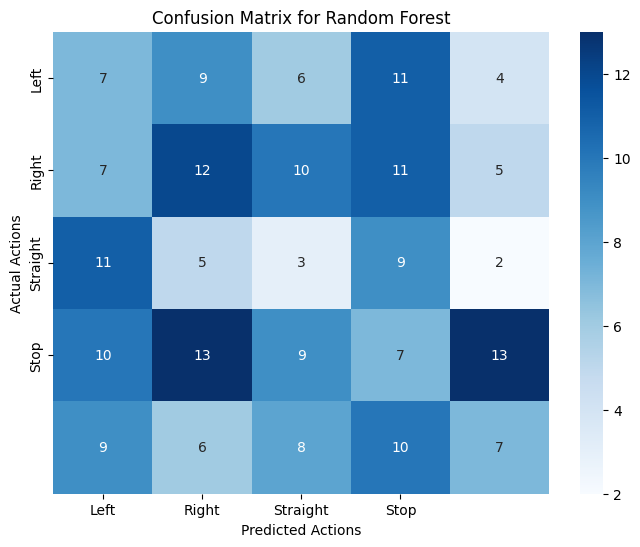

SVM - Accuracy: 0.19, F1 Score: 0.17
              precision    recall  f1-score   support

       biker       0.23      0.41      0.29        37
         car       0.23      0.24      0.24        45
  pedestrian       0.08      0.10      0.09        30
trafficLight       0.16      0.10      0.12        52
       truck       0.17      0.10      0.12        40

    accuracy                           0.19       204
   macro avg       0.17      0.19      0.17       204
weighted avg       0.18      0.19      0.17       204



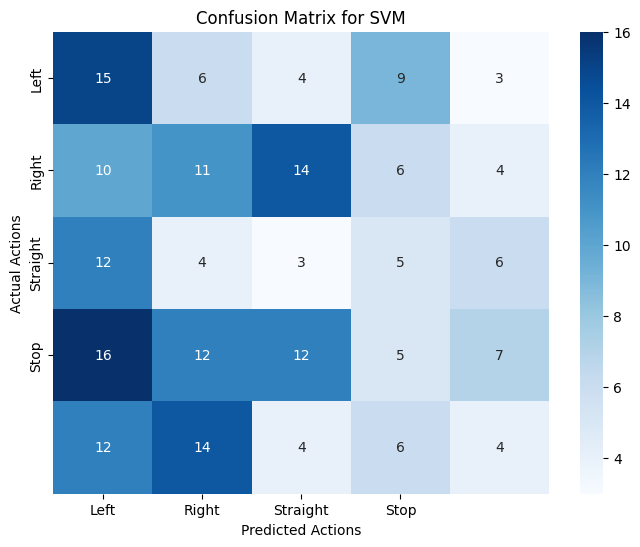

K-Nearest Neighbors - Accuracy: 0.23, F1 Score: 0.22
              precision    recall  f1-score   support

       biker       0.17      0.27      0.21        37
         car       0.32      0.27      0.29        45
  pedestrian       0.15      0.17      0.16        30
trafficLight       0.30      0.21      0.25        52
       truck       0.22      0.20      0.21        40

    accuracy                           0.23       204
   macro avg       0.23      0.22      0.22       204
weighted avg       0.24      0.23      0.23       204



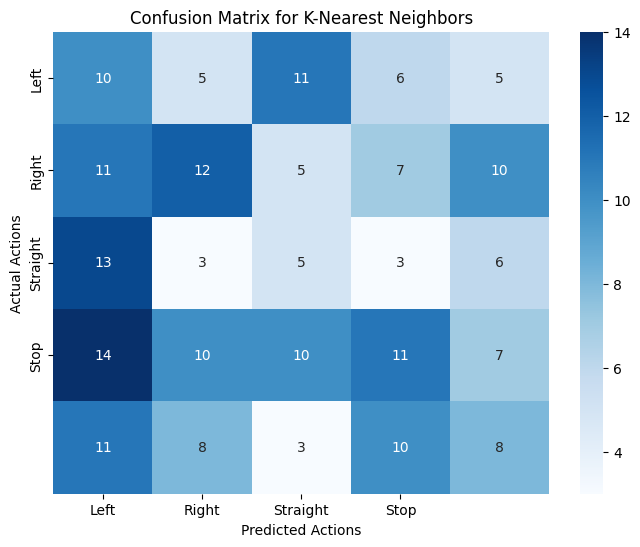

In [81]:
# evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results[model_name] = {"Accuracy": accuracy, "F1 Score": f1}
    print(f"{model_name} - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Left', 'Right', 'Straight', 'Stop'],
                yticklabels=['Left', 'Right', 'Straight', 'Stop'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Actions')
    plt.ylabel('Actual Actions')
    plt.show()

In [82]:
# Choose the best model based on F1 score
best_model_name = max(results, key=lambda k: results[k]["F1 Score"])
best_model = models[best_model_name]

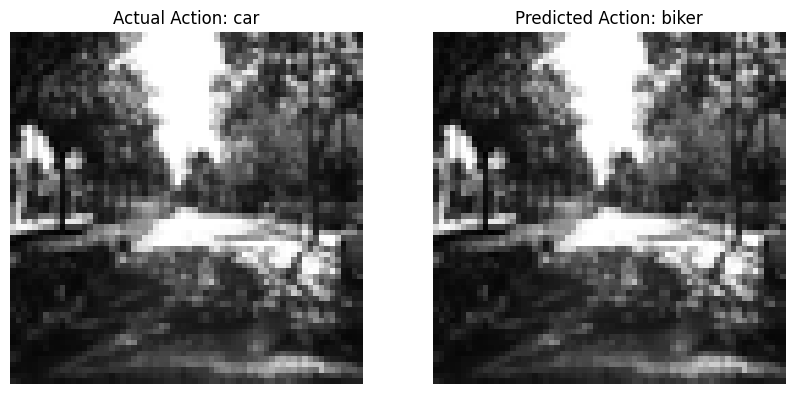

In [84]:
# Prediction on a new sample
sample_index = 0  # Select a sample index for demonstration
sample_image_features = X_test[sample_index].reshape(1, -1)
predicted_label = best_model.predict(sample_image_features)

# Visualization function to compare actual vs predicted images side-by-side
def visualize_comparison(original_image, predicted_label, actual_label):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Assuming your y_test labels are strings like 'Left', 'Right', etc.
    # Update action_labels to include all possible labels in your dataset:
    action_labels = ['Left', 'Right', 'Straight', 'Stop', 'pedestrian', 'truck', 'biker', 'car']

    # Find the index of the actual label in the action_labels list
    # If actual_label is not in action_labels, it will raise a ValueError
    # Use try-except to handle this case
    try:
        actual_label_index = action_labels.index(actual_label)
    except ValueError:
        print(f"Warning: Actual label '{actual_label}' not found in action_labels. Using label 'Unknown'.")
        actual_label_index = -1  # Use -1 as an index for unknown labels

    # Display the actual image with its label
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title(f"Actual Action: {actual_label if actual_label_index != -1 else 'Unknown'}")
    axes[0].axis('off')

    # Display the predicted image with its label
    # Adjust predicted label handling based on your model's output
    try:
        predicted_label_text = predicted_label[0] # Changed this line

    except IndexError:
        print(f"Warning: Predicted label index {predicted_label[0]} out of range for action_labels. Using label 'Unknown'.")
        predicted_label_text = 'Unknown'

    axes[1].imshow(original_image, cmap='gray')  # Reusing the same image for predicted visualization
    axes[1].set_title(f"Predicted Action: {predicted_label_text}")
    axes[1].axis('off')

    plt.show()

# Display the sample prediction with the actual and predicted actions side-by-side
visualize_comparison(images[sample_index], predicted_label, y_test[sample_index]) # Assuming sample_index is within the bounds of your dataset